Here, i want to talk about one of the most popular CNN architectures - ResNet

### Problems

"Deep neural networks for Image Recognition" starts with the following words: "Deeper neural networks are more difficult to train". And this is absolute true. While evidence in that time revealed that depth is matter, in reality - training such thing was a trial.

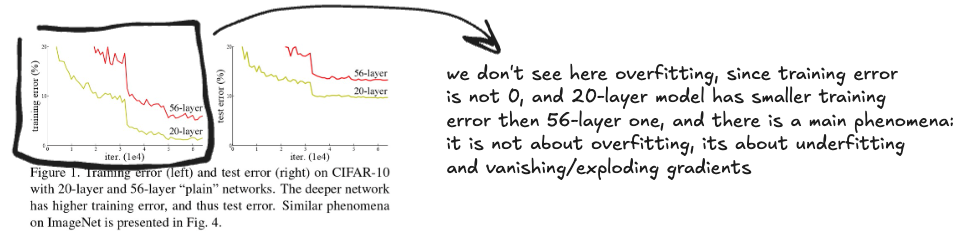

In the image above we see the main problem, and this is the fact that deeper neural networks are not overffited, they are rather - underfitted, and this is affected by the exploding/vanishing gradients that depends on activation function.

But why we don't have normal gradients, even if we have normalization, correct parameter initialization and so on?

Actually we can, but this is very difficult task. And we move on to the second problem - degradation. Let's say you have a 20-layer network that performs well. If you add 30 more layers to make it a 50-layer network, in theory, it should perform at least as well as the 20-layer version. All those extra 30 layers have to do is learn the identity mapping (meaning they just pass the input forward exactly as it is, without changing it).

The problem is that it is notoriously difficult for a standard stack of non-linear layers to learn a perfect identity function. The optimizer struggles to find the exact combination of weights and biases across multiple layers that simply outputs the input.

### Solution

Researchers came up with a very elegant solution to the degradation problem: skip (or residual) connections. Let the input to a block of layers be $X$. In a standard plain network, we pass $X$ through a stack of non-linear layers, hoping it learns an underlying mapping that we will call $H(X)$.

Ideally, we expect $H(X)$ to perform no worse than the input $X$ itself. It should learn additional features to decrease the overall training error. Crucially, a deeper model should have a training error no greater than its shallower counterpart.

**The Problem with Plain Networks:** For the added layers to perform no worse than the previous layers, they would need to perfectly learn an identity mapping, where $H(X) = X$. In practice, it is notoriously difficult for a complex stack of non-linear layers to orchestrate their weights into perfect identity matrices.

**The Residual Solution:** ResNets change the paradigm. Instead of hoping the stack of layers learns the full underlying mapping $H(X)$, we force the network to learn a residual mapping, denoted as $F(X)$. The final output of the block is the sum of this residual mapping and the original input:
$$H(X) = F(X) + X$$

Why is this so powerful? It means we force the model to only learn the "new" information (the residual difference, $F(X)$). In the worst-case scenario, if the layers cannot learn any new useful features, the optimizer simply drives the weights of $F(X)$ toward zero.

Pushing weights to zero is mathematically much easier than orchestrating a perfect identity matrix. If the network successfully zeroes out the weights, then $F(X) = 0$, which leaves us with $H(X) = X$. This elegant trick guarantees that adding more layers will not increase the training error.

### Architecture

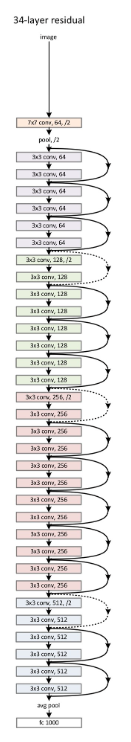

In [9]:
import sys
import os

sys.path.append(os.path.abspath("../..")) 

from utils.utils import min_max_scaling, \
    set_random_seeds, plot_images, get_top_k_confident_mistakes, compute_FLOPS, compare_architectures, \
    plot_top_mistakes, plot_training_results, plot_filters_and_feature_maps, count_params, get_gpu
from models.AlexNet import AlexNet
from models.VGG import VGG, get_vgg_features
from models.NiN import NiN, NiN_without_AGP
from engine.DatasetProvider import DatasetProvider, DatasetName
from engine.Trainer import Trainer
from models.AlexNet import AlexNet
from models.GoogLeNet import GoogLeNet
from models.ResNet import ResNet34
import torchvision
from torchvision.transforms import transforms
import torch.nn.functional as F
import torch
from torch import nn
import torch.utils.data as data
from torchinfo import summary
import copy
import numpy as np
import matplotlib.pyplot as plt

Below i have implemented the architecture as in ResNet-34:

In [8]:
import torch
from torch import nn

class ResBlockExample(nn.Module):
    def __init__(self, in_channels, out_channels, is_downsample=False):
        super().__init__()
        self.is_downsample = is_downsample

        stride = 2 if is_downsample else 1

        self.conv1 = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=(3, 3),
            padding=(1, 1),
            stride=stride,
            bias=False
        )

        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=(1, 1),
            bias=False
        )

        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        if is_downsample:
            self.downsample = nn.Sequential( 
                # we downsample the input X, and map: in_channels -> out_channels
                nn.Conv2d(
                    in_channels=in_channels, 
                    out_channels=out_channels, 
                    kernel_size=(1, 1),
                    stride=2,
                    bias=False
                ),
                nn.BatchNorm2d(num_features=out_channels)
            )

    def forward(self, X):
        F = self.relu(self.bn1(self.conv1(X)))
        F = self.bn2(self.conv2(F))

        if self.is_downsample:
            X = self.downsample(X)

        return self.relu(X + F)


class ResNet34Example(nn.Module):
    def __init__(self, in_channels, out_features):
        super().__init__()

        # input: 224 x 224 x 3

        self.conv1 = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=64, 
            kernel_size=(7, 7), 
            stride=2, 
            padding=(3, 3),
            bias=False
        )

        self.bn1 = nn.BatchNorm2d(num_features=64)

        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1))

        self.layer1 = nn.Sequential(
            ResBlockExample(in_channels=64, out_channels=64, is_downsample=False),
            ResBlockExample(in_channels=64, out_channels=64, is_downsample=False),
            ResBlockExample(in_channels=64, out_channels=64, is_downsample=False)
        )

        self.layer2 = nn.Sequential(
            ResBlockExample(in_channels=64, out_channels=128, is_downsample=True),
            ResBlockExample(in_channels=128, out_channels=128, is_downsample=False),
            ResBlockExample(in_channels=128, out_channels=128, is_downsample=False),
            ResBlockExample(in_channels=128, out_channels=128, is_downsample=False),
        )

        self.layer3 = nn.Sequential(
            ResBlockExample(in_channels=128, out_channels=256, is_downsample=True),
            ResBlockExample(in_channels=256, out_channels=256, is_downsample=False),
            ResBlockExample(in_channels=256, out_channels=256, is_downsample=False),
            ResBlockExample(in_channels=256, out_channels=256, is_downsample=False),
            ResBlockExample(in_channels=256, out_channels=256, is_downsample=False),
            ResBlockExample(in_channels=256, out_channels=256, is_downsample=False),
        )

        self.layer4 = nn.Sequential(
            ResBlockExample(in_channels=256, out_channels=512, is_downsample=True),
            ResBlockExample(in_channels=512, out_channels=512, is_downsample=False),
            ResBlockExample(in_channels=512, out_channels=512, is_downsample=False),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = nn.Flatten()

        self.fc = nn.Linear(in_features=512, out_features=out_features)

    def forward(self, X):
        X = self.maxpool(self.relu(self.bn1(self.conv1(X))))

        X = self.layer1(X)
        X = self.layer2(X)
        X = self.layer3(X)
        X = self.layer4(X)

        X = self.flatten(self.avgpool(X))

        return self.fc(X)

In [10]:
model = ResNet34(in_channels=3, out_features=10)

model

ResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

Let's compare with other models:

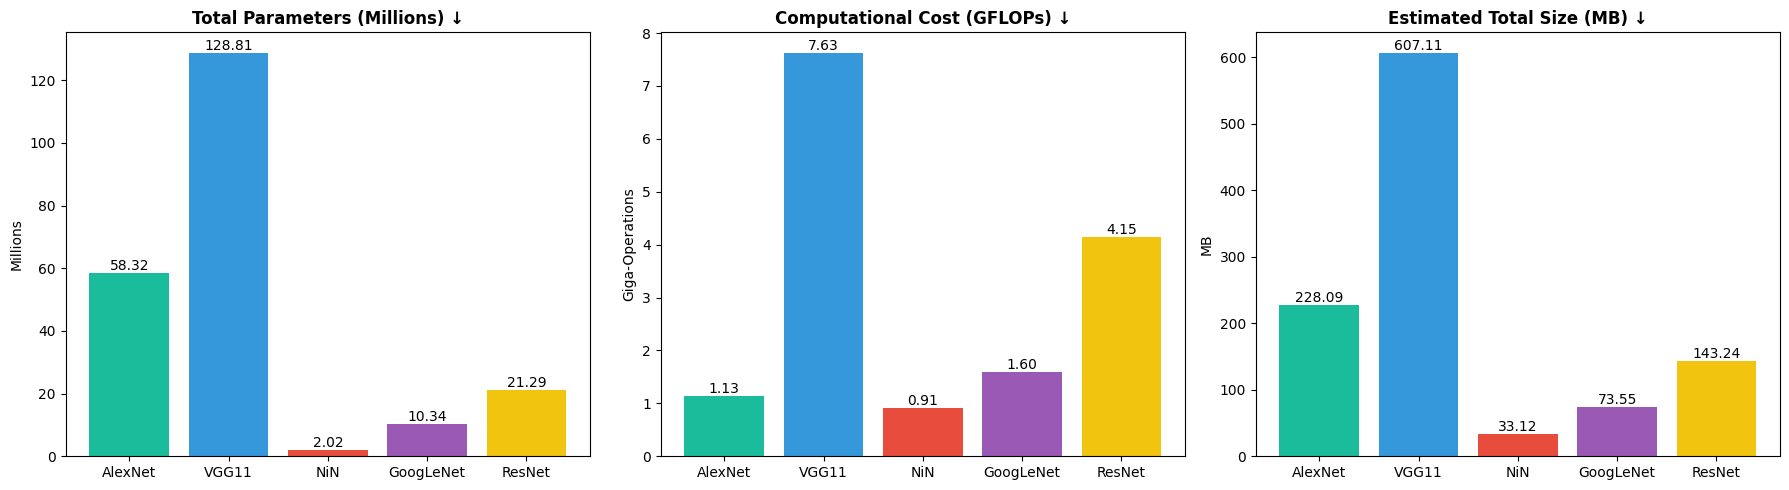

In [11]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

models_to_compare = {
    "AlexNet": AlexNet(3, 10),
    "VGG11": VGG(3, 10, config=vgg11_config),
    "NiN": NiN(3, 10),
    "GoogLeNet": GoogLeNet(3, 10),
    "ResNet": model
}

compare_architectures(models_to_compare, input_size=(1, 3, 227, 227))

Despite ResNet-34 has 34 parameterized layers - it still smaller than VGG-11